In [ ]:
import pandas as pd

pd.set_option('max_columns', None)

In [ ]:
# Read from CSV
posts_df = pd.read_csv("2018_posts.csv")
comms_df = pd.read_csv("2018_comments.csv")

# # Read from PKL
# posts_df = pd.read_pickle("2018_posts.pkl")
# comms_df = pd.read_pickle("2018_comments.pkl")

print(posts_df.shape, comms_df.shape)

In [ ]:
posts_df[:2]

In [ ]:
comms_df[:2]

In [111]:
import networkx as nx

gAll = {}

for _, post in posts_df.iterrows():
    g = nx.DiGraph()
    post_id = post['id']
    userResponders = {}
    for _, comment in comms_df[comms_df['link_id']==f't3_{post_id}'].iterrows():
        parentID = comment['parent_id']
        currentID = 't1_'+comment['id']
        author = comment['author']
        g.add_edge(parentID, currentID)
        g.nodes[currentID]['author'] = author
        if author not in userResponders:
            userResponders[author] = []
        userResponders[author].append(currentID)    
    gAll[f't3_{post_id}'] = {
        'post_graph': g,
        'user_op': post['author'],
        'user_responders': userResponders,
    }

In [112]:
temp_max = ''
maxcount = 0
for pid in list(gAll.keys())[:1000]:
    commcount = sum([len(e) for e in gAll[pid]['user_responders']])
    if commcount > maxcount:
        maxcount = commcount
        temp_max = pid
print(temp_max)

t3_7znly3


t3_8bdpc6
Robnoneman
{'BadManJefe': ['t1_dx5wzp4'], 'WedgeTailedRoo': ['t1_dx5x1w3', 't1_dx5xlnz', 't1_dx5y6eb', 't1_dx5zqvy'], 'Robnoneman': ['t1_dx5x79q', 't1_dx5xj0y', 't1_dx5xpow', 't1_dx5xtnu', 't1_dx5xy8i', 't1_dx5y8og', 't1_dx5yxq7', 't1_dx5zi4l', 't1_dx60cuu', 't1_dx614xc', 't1_dx64ece', 't1_dx65nj6', 't1_dx67eox', 't1_dx6812j', 't1_dx68c0b', 't1_dx68n7l', 't1_dx68xyt', 't1_dx699fr', 't1_dx6v9yo', 't1_dx702ul', 't1_dx75bf9'], 'ryanpreece': ['t1_dx5xc4p'], 'simiwood': ['t1_dx5xm69', 't1_dx5y5g0'], 'Tank7106': ['t1_dx5y0tl', 't1_dx5yolv'], 'jacked_johnson': ['t1_dx5zr2f', 't1_dy2k8pn', 't1_dy2vnvi', 't1_dy2wjbl', 't1_dy2x15u', 't1_dy2xvi4', 't1_e1aiq94', 't1_e667z6l', 't1_e668zch', 't1_e669gbl', 't1_e669szq'], 'skepticetoh': ['t1_dx5zuqw'], 'teqsutiljebelwij': ['t1_dx602tg'], 'Quicksilver_328': ['t1_dx60fg8'], 'Jess_needs_tequila': ['t1_dx621uj', 't1_dx7726h', 't1_dx772ky'], 'noobucantbeat': ['t1_dx62vf0'], 'quihabla': ['t1_dx63fz2'], 'darksun137': ['t1_dx63k8l'], 'QueenWinosauru

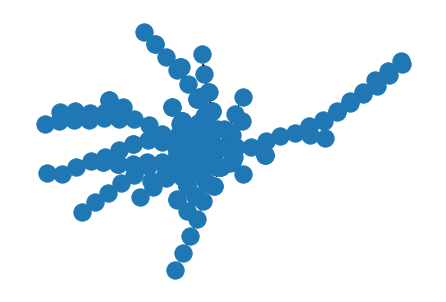

In [113]:
# test out the graph building
postID = 't3_8bdpc6' # list(gAll.keys())[9999]
postG = gAll[postID]['post_graph']
# print(postG.nodes.data())
nx.draw_kamada_kawai(
    postG, 
#     node_color=[
#         d['comment_author'] if 'comment_author' in d else gAll[postID]['user_op']
#         for (n,d) in postG.nodes.data()
#     ]
)
print(postID)
print(gAll[postID]['user_op'])
print(gAll[postID]['user_responders'])

In [121]:
# count how many branches a user has touched
# path metric:
# count of how many unique paths are needed for all of the user's posts to be reached
def branch_count(username, postID):
    # retrieve graph we are working with
    g = gAll[postID]['post_graph']
    # calculate path to each of the poster's comments
    commentPaths = {}
    for cID in gAll[postID]['user_responders'][username]:
        try:
            commentPaths[cID] = nx.shortest_path(g, postID, cID)
        except:
            continue
    # starting from longest path, remove all comments along that path (since theyre not unique)
    pathCount = 0
    while len(commentPaths) > 0:
#         print(commentPaths)
        deepestCID = sorted(
            [(k, len(commentPaths[k])) for k in commentPaths],
            key=(lambda x: x[1]),
        )
        deepestPath = commentPaths[deepestCID[-1][0]]
        for cID in deepestPath:
            commentPaths.pop(cID, None)
        pathCount += 1
    return pathCount

username = "Robnoneman"
postID = "t3_8bdpc6"
print(branch_count_paths(username, postID))

14


(2.625, 1.0)


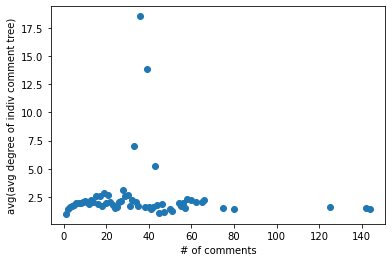

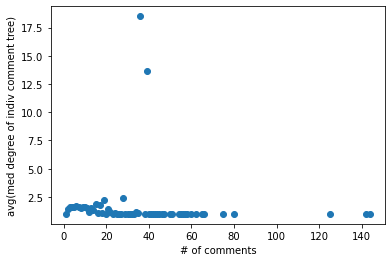

In [118]:
import statistics

# higher = more breadth
def branchiness(username, postID, getGraph=False):
    # retrieve graph we are working with
    g = gAll[postID]['post_graph']
    # calculate path to each of the poster's comments
    commentPaths = {}
    for cID in gAll[postID]['user_responders'][username]:
        try:
            commentPaths[cID] = nx.shortest_path(g, postID, cID)
        finally:
            # print(f'{cID} nonexistent comment?')
            continue
    # starting from shortest path, build out tree of direct dependencies
    gPath = nx.DiGraph()
    nodesAdded = [postID]
    while len(commentPaths) > 0:
#         print(commentPaths)
        closestCID = sorted(
            [(k, len(commentPaths[k])) for k in commentPaths],
            key=(lambda x: x[1]),
        )
        closestPath = commentPaths[closestCID[0][0]]
        closestCID = closestPath[-1]
        topLevel = True
        for n in nodesAdded:
            if nx.has_path(g, n, closestCID):
                topLevel = False
                gPath.add_edge(n, closestCID)
                nodesAdded = [closestCID]+nodesAdded
                break
        if topLevel:
            gPath.add_edge(postID, closestCID)
            nodesAdded = [closestCID]+nodesAdded
        commentPaths.pop(closestCID, None)
    # calculate average degree
    degrees = [d for (n,d) in gPath.out_degree() if d!=0]
    if len(degrees)==0:
        # there was some hole in the graph between ALL of a user's comments and the main post...
        return None, None
    degreeAvg = sum(degrees)/len(degrees)
    degreeMed = statistics.median(degrees)
    if getGraph:
        return degreeAvg, gPath
    return degreeAvg, degreeMed

username = "Robnoneman"
postID = "t3_8bdpc6"
print(branchiness(username, postID))

# Sanity check this metric?

import math
import matplotlib.pyplot as plt

t = []
for postID in gAll:
    for uname in gAll[postID]['user_responders']:
        if uname!=gAll[postID]['user_op']:
            brtuple = branchiness(uname, postID)
            if brtuple[0] is not None:
                t.append((
                    len(gAll[postID]['user_responders'][uname]),
                    brtuple,
                ))

tNext = []
for l in set([i[0] for i in t]):
    v = [i[1][0] for i in t if i[0]==l]
    v = sum(v)/len(v)
    tNext.append( (l, v) )
plt.scatter(
    [x for (x, _) in tNext], 
    [y for (_, y) in tNext], 
)
plt.xlabel('# of comments')
plt.ylabel('avg(avg degree of indiv comment tree)')
plt.show()

tNext = []
for l in set([i[0] for i in t]):
    v = [i[1][1] for i in t if i[0]==l]
    v = sum(v)/len(v)
    tNext.append( (l, v) )
plt.scatter(
    [x for (x, _) in tNext], 
    [y for (_, y) in tNext], 
)
plt.xlabel('# of comments')
plt.ylabel('avg(med degree of indiv comment tree)')
plt.show()

In [133]:
restricted_list = ['AutoModerator']

# get branch count for responders
distribCount = {} # map from [number of branches]: [users who have had that number]
userCount = {}    # map from [usernames]: [branch distribution they've done]
userBCount = {}    # map from [usernames]: [branchiness distribution they've done]
for postID in gAll.keys():
    for u in gAll[postID]['user_responders']:
        if u!=gAll[postID]['user_op'] and u not in restricted_list:
            count = branch_count(u, postID)
            if count!=0:
                ctrlcount = branchiness(u, postID)
                if count not in distribCount:
                    distribCount[count] = []
                distribCount[count].append(u)
                if u not in userCount:
                    userCount[u] = []
                userCount[u].append(count)
                if u not in userBCount:
                    userBCount[u] = []
                userBCount[u].append(ctrlcount)

[(1, 69246), (2, 9976), (3, 2979), (4, 1258), (5, 655), (6, 366), (7, 242), (8, 128), (9, 98), (10, 59), (11, 39), (12, 30), (13, 28), (14, 16), (15, 13), (16, 10), (17, 9), (18, 7), (19, 4), (20, 7), (21, 2), (22, 4), (23, 6), (24, 1), (25, 4), (26, 1), (27, 3), (28, 2), (31, 1), (33, 1), (34, 1), (35, 1), (36, 1), (38, 1), (39, 2), (42, 1), (45, 1), (47, 1), (48, 1)]


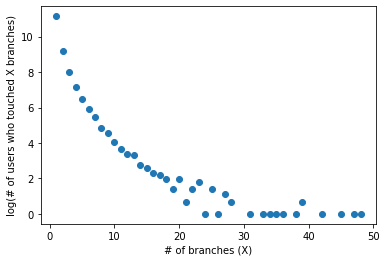

In [134]:
import math
import matplotlib.pyplot as plt

t = [(k, len(set(distribCount[k])), set(distribCount[k])) for k in distribCount.keys()]
t = [(a,b,c) for (a,b,c) in t if b!=0]
t = sorted(t, key=lambda x: x[0])
print([(a,b) for (a,b,c) in t])

plt.scatter(
    [b for (b, _, _) in t], 
    [math.log(fq) for (_, fq, _) in t], 
)
plt.xlabel('# of branches (X)')
plt.ylabel('log(# of users who touched X branches)')
plt.show()

(username, avg branches/post, max branches/post, #posts touched)
('SnausageFest', 1.2654320987654322, 7, 972)
('FIVE_DARRA_NO_HARRA', 1.1684636118598384, 4, 742)
('Rivka333', 1.3937753721244925, 8, 739)
('iowaclass', 1.0709090909090908, 11, 550)
('moongirl12', 1.1204379562043796, 3, 548)
('LearnedButt', 1.1620553359683794, 6, 506)
('simiwood', 1.0245398773006136, 2, 489)
('derpplerp', 1.3620309050772628, 9, 453)
('PremiumRecyclingBin', 1.025, 2, 440)
('Aurion7', 1.1503416856492028, 4, 439)


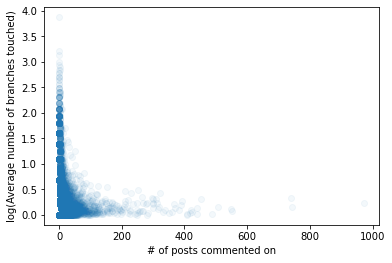

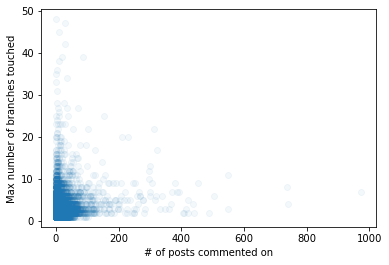

In [135]:
import math
import matplotlib.pyplot as plt

t = [(k, sum(userCount[k]), len(userCount[k]), max(userCount[k])) for k in userCount.keys()]
t = sorted(t, key=lambda x: x[2], reverse=True)
print('(username, avg branches/post, max branches/post, #posts touched)')
for i in ([(a,b/c,d,c) for (a,b,c,d) in t])[:10]:
    print(i)

plt.scatter(
    [pc for (_, _, pc, _) in t], 
    [math.log(sumB/numB) for (_, sumB, numB, _) in t],
    alpha=0.05
)
plt.xlabel('# of posts commented on')
plt.ylabel('log(Average number of branches touched)')
plt.show()

plt.scatter(
    [pc for (_, _, pc, _) in t], 
    [maxB for (_, _, _, maxB) in t],
    alpha=0.05
)
plt.xlabel('# of posts commented on')
plt.ylabel('Max number of branches touched')
plt.show()

(username, avg branchiness/post, max branchiness/post, #posts touched)
('SnausageFest', 1.1556523123652753, 7.0, 972)
('FIVE_DARRA_NO_HARRA', 1.1154312668463613, 3.0, 742)
('Rivka333', 1.3676138926477222, 8.0, 739)
('iowaclass', 1.0310389610389612, 2.0, 550)
('moongirl12', 1.0588090893291624, 2.0, 548)
('LearnedButt', 1.114553924336533, 6.0, 506)
('simiwood', 1.0120654396728015, 2.0, 489)
('derpplerp', 1.2230316409124355, 8.0, 453)
('PremiumRecyclingBin', 1.017992424242424, 2.0, 440)
('Aurion7', 1.1295368261199696, 4.0, 439)


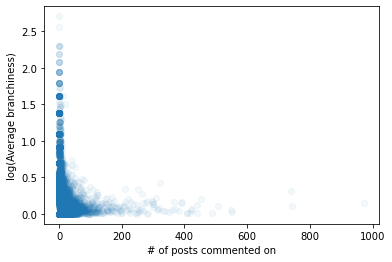

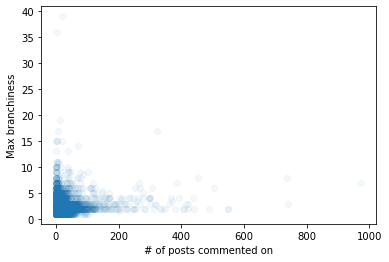

In [138]:
import math
import matplotlib.pyplot as plt

t = [(k, sum([e[0] for e in userBCount[k]]), len([e[0] for e in userBCount[k]]), max([e[0] for e in userBCount[k]])) for k in userBCount.keys()]
t = sorted(t, key=lambda x: x[2], reverse=True)
print('(username, avg branchiness/post, max branchiness/post, #posts touched)')
for i in ([(a,b/c,d,c) for (a,b,c,d) in t])[:10]:
    print(i)

plt.scatter(
    [pc for (_, _, pc, _) in t], 
    [math.log(sumB/numB) for (_, sumB, numB, _) in t],
    alpha=0.05
)
plt.xlabel('# of posts commented on')
plt.ylabel('log(Average branchiness)')
plt.show()

plt.scatter(
    [pc for (_, _, pc, _) in t], 
    [maxB for (_, _, _, maxB) in t],
    alpha=0.05
)
plt.xlabel('# of posts commented on')
plt.ylabel('Max branchiness')
plt.show()

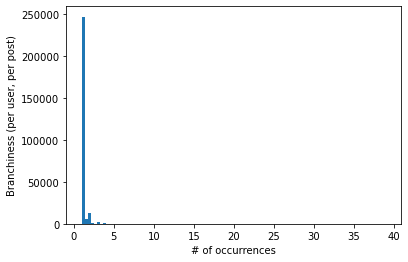

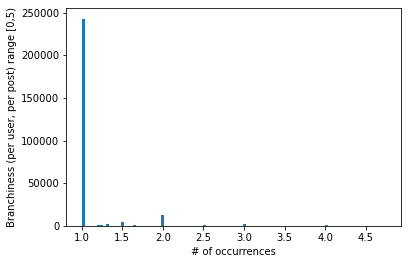

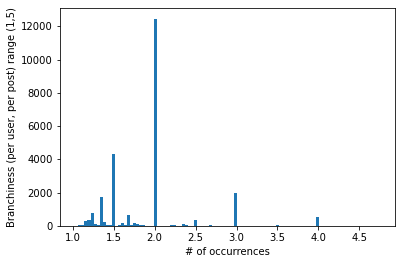

In [145]:
import math
import matplotlib.pyplot as plt

t = [[e[0] for e in userBCount[k]] for k in userBCount.keys()]
t = [i for sl in t for i in sl]
plt.hist(t, bins=100)
plt.xlabel('# of occurrences')
plt.ylabel('Branchiness (per user, per post)')
plt.show()

t = [[e[0] for e in userBCount[k]] for k in userBCount.keys()]
t = [i for sl in t for i in sl]
t = [i for i in t if i<5]
plt.hist(t, bins=100)
plt.xlabel('# of occurrences')
plt.ylabel('Branchiness (per user, per post) range [0,5)')
plt.show()

t = [[e[0] for e in userBCount[k]] for k in userBCount.keys()]
t = [i for sl in t for i in sl]
t = [i for i in t if i<5 and i>1]
plt.hist(t, bins=100)
plt.xlabel('# of occurrences')
plt.ylabel('Branchiness (per user, per post) range (1,5)')
plt.show()